In [1]:
import pandas as pd 
from scipy.stats import zscore
from matplotlib import pyplot as plt
import numpy as np

In [2]:
sensitive_quantile = 0.2
resistant_quantile = 0.8

VAR_FILTER_Q = 0.75 # filter out genes with variance below this quantile

ALPHA = 0.01
ALPHA2 = 0.01

In [6]:
resp = pd.read_csv('../../data/tkg_raw/beataml_probit_curve_fits_v4_dbgap.txt', sep='\t')[lambda x: (x.converged) & (x.curve_type == 'decreasing') & (x.type == 'single-agent')]
resp.head()

,dbgap_subject_id,dbgap_dnaseq_sample,dbgap_rnaseq_sample,inhibitor,type,status,paper_inclusion,min_conc,max_conc,intercept,...,converged,ic10,ic25,ic50,ic75,ic90,auc,all_gt_50,all_lt_50,curve_type
0,2476,NaN,BA3073R,Axitinib (AG-013736),single-agent,train/test,True,0.0137,10,-0.145371,...,True,0.013700,0.075364,0.632206,5.303377,10.000000,159.484594,False,False,decreasing
2,2476,NaN,BA3073R,Crizotinib (PF-2341066),single-agent,train/test,True,0.0137,10,-0.393883,...,True,0.022507,0.088986,0.409960,1.887455,7.462260,146.947463,False,False,decreasing
3,2476,NaN,BA3073R,Dasatinib,single-agent,train/test,True,0.0014,1,-0.153187,...,True,0.001705,0.025291,0.506219,1.000000,1.000000,201.043243,False,False,decreasing
4,2476,NaN,BA3073R,Erlotinib,single-agent,train/test,True,0.0137,10,-0.220735,...,True,0.034847,0.135294,0.610660,2.756260,10.000000,161.789024,False,False,decreasing
5,2476,NaN,BA3073R,Gefitinib,single-agent,train/test,True,0.0137,10,-0.442359,...,True,0.016818,0.070882,0.350537,1.733322,7.306475,141.189411,False,False,decreasing


In [7]:
druginfo = pd.read_csv('../../extdata/meta/targetome__drug_targets_gene.csv')
druginfo.head()

,inhibitor,Symbol,GeneID,targetome_adj_tier,can_smiles,inchikey,iso_smiles
0,ABT-737,BAD,572,TIER_1,CN(C)CCC(CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O)(=O...,HPLNQCPCUACXLM-PGUFJCEWSA-N,CN(C)CC[C@H](CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O...
1,Palbociclib,CCND1,595,TIER_1,CC1=C(C(=O)N(C2=NC(=NC=C12)NC3=NC=C(C=C3)N4CCN...,AHJRHEGDXFFMBM-UHFFFAOYSA-N,CC1=C(C(=O)N(C2=NC(=NC=C12)NC3=NC=C(C=C3)N4CCN...
2,Flavopiridol,CCNT1,904,TIER_1,CN1CCC(C(C1)O)C2=C(C=C(C3=C2OC(=CC3=O)C4=CC=CC...,BIIVYFLTOXDAOV-YVEFUNNKSA-N,CN1CC[C@@H]([C@@H](C1)O)C2=C(C=C(C3=C2OC(=CC3=...
3,Bortezomib (Velcade),PSMA1,5682,TIER_1,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,GXJABQQUPOEUTA-RDJZCZTQSA-N,B([C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)...
4,Bortezomib (Velcade),PSMA2,5683,TIER_1,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,GXJABQQUPOEUTA-RDJZCZTQSA-N,B([C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)...


In [8]:
drug2inchi = druginfo[['inhibitor', 'inchikey']].drop_duplicates() 

In [9]:
resp = resp[['dbgap_subject_id', 'dbgap_dnaseq_sample', 'dbgap_rnaseq_sample', 'inhibitor', 'auc']].dropna().merge(drug2inchi, on='inhibitor', how='inner')

print('# drugs:', resp.inhibitor.nunique())
print('# subjects:', resp.dbgap_subject_id.nunique())
print('# samples:', resp.dbgap_rnaseq_sample.nunique())

# drugs: 85
# subjects: 470
# samples: 513


In [10]:
# Define the quantiles for sensitivity and resistance

# Function to label sensitivity and resistance
def label_response(df):
    df['label'] = 'intermediate'
    df.loc[df['auc'] <= df['auc'].quantile(sensitive_quantile), 'label'] = 'sensitive'
    df.loc[df['auc'] >= df['auc'].quantile(resistant_quantile), 'label'] = 'resistant'
    return df

# Apply the function to each group of inhibitors
resp = resp.groupby('inhibitor').apply(label_response)

resp = resp.reset_index(drop=True)
# Display the updated dataframe
resp.head()

/tmp/ipykernel_12858/976642720.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resp = resp.groupby('inhibitor').apply(label_response)


,dbgap_subject_id,dbgap_dnaseq_sample,dbgap_rnaseq_sample,inhibitor,auc,inchikey,label
0,2446,BA2236D,BA2236R,17-AAG (Tanespimycin),217.504830,AYUNIORJHRXIBJ-TXHRRWQRSA-N,resistant
1,2580,BA3042D,BA3042R,17-AAG (Tanespimycin),231.164406,AYUNIORJHRXIBJ-TXHRRWQRSA-N,resistant
2,2491,BA2003D,BA2003R,17-AAG (Tanespimycin),131.931243,AYUNIORJHRXIBJ-TXHRRWQRSA-N,intermediate
3,2489,BA2488D,BA2488R,17-AAG (Tanespimycin),274.281000,AYUNIORJHRXIBJ-TXHRRWQRSA-N,resistant
4,2606,BA3379D,BA3379R,17-AAG (Tanespimycin),185.440288,AYUNIORJHRXIBJ-TXHRRWQRSA-N,intermediate


In [11]:
resp[['inhibitor','auc']].groupby('inhibitor').agg(['mean', 'std', 'count', 'min', 'max'])

auc                                           
                             mean        std count           min         max
inhibitor                                                                   
17-AAG (Tanespimycin)  149.174076  48.810872   430  8.085970e-09  274.281000
A-674563               133.882833  48.115144   453  8.085970e-09  271.168565
ABT-737                182.052500  55.122933   218  3.410674e+00  278.422467
AT7519                 132.228279  38.859221   429  9.567337e+00  263.236829
Alisertib (MLN8237)    225.912364  40.573178   428  1.346102e+01  286.299128
...                           ...        ...   ...           ...         ...
Vandetanib (ZD6474)    219.272966  44.838069   393  8.085970e-09  286.253958
Vatalanib (PTK787)     215.620972  43.415094   404  8.085970e-09  286.135169
Venetoclax             145.975631  77.696796   345  8.085970e-09  286.304063
Vismodegib (GDC-0449)  264.368441  39.306263   277  1.254913e+01  286.326113
XMD 8-87               206.510734  46.864307    39  9.880429e+01  286.306835

[85 rows x 5 columns]

In [12]:
resp.groupby('label').count()

,dbgap_subject_id,dbgap_dnaseq_sample,dbgap_rnaseq_sample,inhibitor,auc,inchikey
label,,,,,,
intermediate,17457,17457,17457,17457,17457,17457
resistant,5869,5869,5869,5869,5869,5869
sensitive,5869,5869,5869,5869,5869,5869


In [13]:
resp_sens_rel_fwd = resp[lambda x: x.label == 'sensitive'][['dbgap_subject_id', 'inchikey']].drop_duplicates().rename({'dbgap_subject_id':'src', 'inchikey':'dst'}, axis=1).assign(src_type='dbgap_subject', dst_type='drug', relation='sensitive_to_fwd')
resp_res_rel_fwd = resp[lambda x: x.label == 'resistant'][['dbgap_subject_id', 'inchikey']].drop_duplicates().rename({'dbgap_subject_id':'src', 'inchikey':'dst'}, axis=1).assign(src_type='dbgap_subject', dst_type='drug', relation='resistant_to_fwd')

resp_sens_rel_rev = resp[lambda x: x.label == 'sensitive'][['dbgap_subject_id', 'inchikey']].drop_duplicates().rename({'dbgap_subject_id':'dst', 'inchikey':'src'}, axis=1).assign(dst_type='dbgap_subject', src_type='drug', relation='sensitive_to_rev')
resp_res_rel_rev = resp[lambda x: x.label == 'resistant'][['dbgap_subject_id', 'inchikey']].drop_duplicates().rename({'dbgap_subject_id':'dst', 'inchikey':'src'}, axis=1).assign(dst_type='dbgap_subject', src_type='drug', relation='resistant_to_rev')


resp_sens_rel_fwd.dropna().to_csv('../../extdata/relations/beataml_sens_rel_fwd.csv', index=False)
resp_res_rel_fwd.dropna().to_csv('../../extdata/relations/beataml_res_rel_fwd.csv', index=False)
resp_sens_rel_rev.dropna().to_csv('../../extdata/relations/beataml_sens_rel_rev.csv', index=False)
resp_res_rel_rev.dropna().to_csv('../../extdata/relations/beataml_res_rel_rev.csv', index=False)

# now mutation... 

In [14]:
gene2aa = pd.read_csv('../../extdata/meta/gene2aa.csv')

genespace = gene2aa.gene_name.unique()

In [15]:
mut = pd.read_csv('../../data/tkg_raw/beataml_wes_wv1to4_mutations_dbgap.txt', sep='\t')
mut = mut[['dbgap_sample_id', 'gene', 'symbol', 'variant_classification', 'sift', 'polyphen']].drop_duplicates()
mut = mut[lambda x: x.symbol.isin(genespace)]
mut = mut.assign(sift_short = lambda x: x.sift.str.split('(').str[0], polyphen_short = lambda x: x.polyphen.str.split('(').str[0])
mut.sift_short = mut.sift_short.fillna('')
mut.polyphen_short = mut.polyphen_short.fillna('')

mut = mut.assign(variant_and_sift = mut.variant_classification + '_' + mut.sift_short, variant_and_polyphen = mut.variant_classification + '_' + mut.polyphen_short)
print('# samples:', mut.dbgap_sample_id.nunique())
print('# genes:', mut.gene.nunique())
print('df size:', mut.shape)
mut.head()


# samples: 864
# genes: 2250
df size: (5925, 10)


,dbgap_sample_id,gene,symbol,variant_classification,sift,polyphen,sift_short,polyphen_short,variant_and_sift,variant_and_polyphen
0,BA2336D,ENSG00000168769,TET2,frameshift_variant,NaN,NaN,,,frameshift_variant_,frameshift_variant_
2,BA2336D,ENSG00000181163,NPM1,frameshift_variant,NaN,NaN,,,frameshift_variant_,frameshift_variant_
3,BA2643D,ENSG00000184937,WT1,frameshift_variant,NaN,NaN,,,frameshift_variant_,frameshift_variant_
4,BA2643D,ENSG00000119772,DNMT3A,missense_variant,deleterious(0),probably_damaging(0.993),deleterious,probably_damaging,missense_variant_deleterious,missense_variant_probably_damaging
6,BA2067D,ENSG00000139083,ETV6,frameshift_variant,NaN,NaN,,,frameshift_variant_,frameshift_variant_


In [16]:
mut_rels = mut.groupby('variant_and_sift').count()[['dbgap_sample_id']].sort_values('dbgap_sample_id', ascending=False).reset_index().variant_and_sift[:4].values

mut = mut[lambda x: x.variant_and_sift.isin(mut_rels)]

sample2subject = resp[['dbgap_dnaseq_sample', 'dbgap_subject_id']].drop_duplicates().rename({'dbgap_dnaseq_sample':'dbgap_sample_id'}, axis=1)
mut = mut.merge(sample2subject, on='dbgap_sample_id', how='inner')

mut.head()

,dbgap_sample_id,gene,symbol,variant_classification,sift,polyphen,sift_short,polyphen_short,variant_and_sift,variant_and_polyphen,dbgap_subject_id
0,BA2452D,ENSG00000112576,CCND3,frameshift_variant,NaN,NaN,,,frameshift_variant_,frameshift_variant_,2157
1,BA2452D,ENSG00000119772,DNMT3A,missense_variant,deleterious(0.02),probably_damaging(0.997),deleterious,probably_damaging,missense_variant_deleterious,missense_variant_probably_damaging,2157
2,BA2452D,ENSG00000181163,NPM1,frameshift_variant,NaN,NaN,,,frameshift_variant_,frameshift_variant_,2157
3,BA2452D,ENSG00000164754,RAD21,stop_gained,NaN,NaN,,,stop_gained_,stop_gained_,2157
4,BA3379D,ENSG00000147050,KDM6A,frameshift_variant,NaN,NaN,,,frameshift_variant_,frameshift_variant_,2606


In [17]:
mut = mut[lambda x: ~x.symbol.isna()]

In [18]:
mut_rels

array(['missense_variant_deleterious', 'missense_variant_tolerated',
       'frameshift_variant_', 'stop_gained_'], dtype=object)

In [19]:

for mrel in mut_rels: 

    mrel = mrel.strip('_')
    print(mrel)

    mut_rel_fwd = mut[lambda x: x.variant_and_sift == mrel][['dbgap_subject_id', 'symbol']].drop_duplicates()\
        .rename({'dbgap_subject_id':'src', 'symbol':'dst'}, axis=1).assign(src_type='dbgap_subject', dst_type='gene', relation=f'mut_{mrel}_fwd')
    
    mut_rel_rev = mut[lambda x: x.variant_and_sift == mrel][['dbgap_subject_id', 'symbol']].drop_duplicates()\
        .rename({'dbgap_subject_id':'dst', 'symbol':'src'}, axis=1).assign(dst_type='dbgap_subject', src_type='gene', relation=f'mut_{mrel}_rev')
    
    mut_rel_fwd.dropna().to_csv(f'../../extdata/relations/beataml_mutation_{mrel}_rel_fwd.csv', index=False)
    mut_rel_rev.dropna().to_csv(f'../../extdata/relations/beataml_mutation_{mrel}_rel_rev.csv', index=False)

    print(mrel, mut_rel_fwd.shape[0]) 

missense_variant_deleterious
missense_variant_deleterious 1065
missense_variant_tolerated
missense_variant_tolerated 565
frameshift_variant
frameshift_variant 0
stop_gained
stop_gained 0


In [84]:
mut_rel_rev.head()

,dst,src,dst_type,src_type,relation
3,2157,RAD21,dbgap_subject,gene,mut_stop_gained__rev
8,2034,CDKN2A,dbgap_subject,gene,mut_stop_gained__rev
12,2469,NPHP4,dbgap_subject,gene,mut_stop_gained__rev
24,2469,TET2,dbgap_subject,gene,mut_stop_gained__rev
35,2378,TET2,dbgap_subject,gene,mut_stop_gained__rev


# now expression ... 

In [85]:
expr = pd.read_csv('../../data/tkg_raw/beataml_waves1to4_norm_exp_dbgap.txt', sep='\t')
expr = expr[lambda x: x.biotype == 'protein_coding']
expr = expr[['display_label'] + list(expr.columns[4:])]
expr = expr.groupby('display_label').mean().reset_index()
expr = expr[lambda x: x.display_label.isin(genespace)]
expr.head()

,display_label,BA2392R,BA2611R,BA2506R,BA2430R,BA2448R,BA2730R,BA2845R,BA2326R,BA2341R,...,BA3376R,BA3137R,BA3300R,BA3375R,BA3249R,BA3385R,BA3242R,BA3446R,BA3416R,BA3123R
0,A1BG,-0.437849,-0.802256,-1.073553,-0.851051,-1.303086,-1.453400,-1.253583,-1.086206,-0.581670,...,-0.286764,-1.733767,-0.697874,-0.692659,0.722208,-1.030400,-1.215052,-0.681448,0.939179,-1.095599
1,A2M,1.472384,1.738676,1.229445,1.595418,1.578374,1.222287,1.192150,1.398392,1.024968,...,-3.190298,0.678778,-3.628236,-3.679694,-4.713417,-2.477474,-0.592151,-4.857657,-2.488578,-2.707306
3,A3GALT2,-1.353748,-0.909110,-0.423494,-0.733515,-0.920644,-1.160989,0.170321,-0.220144,0.347347,...,-0.883218,-0.445017,0.267921,1.974174,1.037245,-2.044135,-0.082520,0.100709,0.449334,-1.160989
4,A4GALT,-0.480195,-0.746953,-0.480195,-0.150393,0.041398,-0.435228,-0.344579,-0.320515,-0.296278,...,-1.518044,-1.528851,-1.039442,-3.221429,-1.678256,-1.123034,1.928061,-3.885143,3.119966,0.341832
5,AAAS,6.054079,6.196064,6.080691,6.080691,6.109130,6.085804,6.012926,6.010056,5.940990,...,5.780025,5.271786,5.918355,5.876189,5.037482,5.498308,5.293809,6.139412,5.969878,5.535340


In [86]:
print('# genes:', expr.display_label.nunique())
print('# samples:', expr.shape[1] - 1)


# genes: 9935
# samples: 707


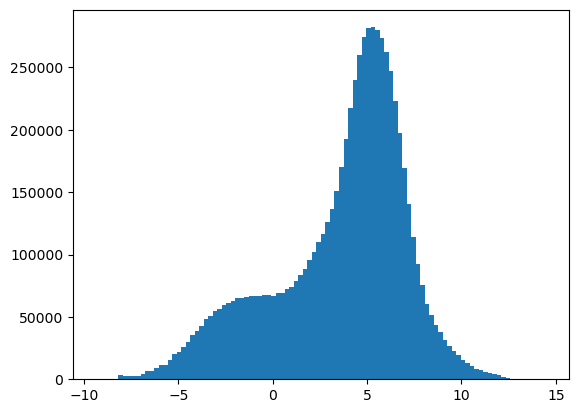

In [87]:
plt.figure()
plt.hist(expr.values[:, 1:].ravel(), bins=100)
plt.show()

In [88]:

# perform a variance filter to remove genes with low variance
expr = expr.assign(var = expr.iloc[:, 1:].var(axis=1))
ngenes = expr.shape[0]
t = expr['var'].quantile(VAR_FILTER_Q)
expr = expr[lambda x: x['var'] > t]
print(f'# genes removed: {ngenes - expr.shape[0]}/{ngenes}')
expr = expr.drop('var', axis=1)

# genes removed: 7451/9935


In [89]:
# zscore by within gene
mu = expr.iloc[:, 1:].mean(axis=1).values.reshape(-1, 1)
std = expr.iloc[:, 1:].std(axis=1).values.reshape(-1, 1)

expr.iloc[:, 1:] = ((expr.iloc[:, 1:].values - mu) / std).astype(np.float32)

In [90]:

expr = expr.melt(id_vars='display_label', var_name='dbgap_rnaseq_sample', value_name='expression')

expr.head()

,display_label,dbgap_rnaseq_sample,expression
0,A2M,BA2392R,0.936036
1,A4GALT,BA2392R,-0.392515
2,AADAT,BA2392R,1.433621
3,AASS,BA2392R,1.873366
4,ABCA13,BA2392R,-0.429367


In [91]:
rna2id = resp[['dbgap_rnaseq_sample', 'dbgap_subject_id']].drop_duplicates()
expr = expr.merge(rna2id, on='dbgap_rnaseq_sample', how='inner')
expr.head()

,display_label,dbgap_rnaseq_sample,expression,dbgap_subject_id
0,A2M,BA2452R,1.250044,2157
1,A4GALT,BA2452R,-0.957175,2157
2,AADAT,BA2452R,-0.120932,2157
3,AASS,BA2452R,-1.867374,2157
4,ABCA13,BA2452R,-0.985413,2157


In [92]:
expr = expr.assign(low_expr = lambda x: x.expression < x.expression.quantile(ALPHA), 
                   high_expr = lambda x: x.expression > x.expression.quantile(1-ALPHA))

expr.head()

,display_label,dbgap_rnaseq_sample,expression,dbgap_subject_id,low_expr,high_expr
0,A2M,BA2452R,1.250044,2157,False,False
1,A4GALT,BA2452R,-0.957175,2157,False,False
2,AADAT,BA2452R,-0.120932,2157,False,False
3,AASS,BA2452R,-1.867374,2157,False,False
4,ABCA13,BA2452R,-0.985413,2157,False,False


In [93]:
high_expr_rel_fwd = expr[lambda x: x.high_expr][['dbgap_subject_id', 'display_label']].drop_duplicates().rename({'dbgap_subject_id':'src', 'display_label':'dst'}, axis=1).assign(src_type='dbgap_subject', dst_type='gene', relation='high_expr_fwd')
low_expr_rel_fwd = expr[lambda x: x.low_expr][['dbgap_subject_id', 'display_label']].drop_duplicates().rename({'dbgap_subject_id':'src', 'display_label':'dst'}, axis=1).assign(src_type='dbgap_subject', dst_type='gene', relation='low_expr_fwd')

high_expr_rel_rev = expr[lambda x: x.high_expr][['dbgap_subject_id', 'display_label']].drop_duplicates().rename({'dbgap_subject_id':'dst', 'display_label':'src'}, axis=1).assign(dst_type='dbgap_subject', src_type='gene', relation='high_expr_rev')
low_expr_rel_rev = expr[lambda x: x.low_expr][['dbgap_subject_id', 'display_label']].drop_duplicates().rename({'dbgap_subject_id':'dst', 'display_label':'src'}, axis=1).assign(dst_type='dbgap_subject', src_type='gene', relation='low_expr_rev')

high_expr_rel_fwd.dropna().to_csv('../../extdata/relations/beataml_high_expr_rel_fwd.csv', index=False)
low_expr_rel_fwd.dropna().to_csv('../../extdata/relations/beataml_low_expr_rel_fwd.csv', index=False)
high_expr_rel_rev.dropna().to_csv('../../extdata/relations/beataml_high_expr_rel_rev.csv', index=False)
low_expr_rel_rev.dropna().to_csv('../../extdata/relations/beataml_low_expr_rel_rev.csv', index=False)


In [94]:
for rel in [high_expr_rel_fwd, low_expr_rel_fwd, high_expr_rel_rev, low_expr_rel_rev]:
    print(rel.shape[0])


11793
11977
11793
11977


# now low expr relation... RAW COUNTS DATA

rationale: proteins that are not expresssed (or very lowly expressed) are unlikely to be functional targets. 

Problem, a ton of genes have low expr. Instead of being patient specific, could make it gene specific. May help delineate functional targets and not. Would decrease number of edges dramatically. 

In [96]:
raise Exception() # stop here, everything below is dev 

Exception: 

In [45]:
expr = pd.read_csv('../../data/tkg_raw/beataml_waves1to4_counts_dbgap.txt', sep='\t')[lambda x: x.biotype == 'protein_coding']
expr = expr[['display_label'] + list(expr.columns[4:])]
expr = expr.groupby('display_label').mean().reset_index()
expr.head()

,display_label,BA2392R,BA2611R,BA2506R,BA2430R,BA2448R,BA2730R,BA2845R,BA2326R,BA2341R,...,BA3376R,BA3137R,BA3300R,BA3375R,BA3249R,BA3385R,BA3242R,BA3446R,BA3416R,BA3123R
0,A1BG,30.0,13.0,21.0,19.0,13.0,10.0,28.0,26.0,37.0,...,26.0,14.0,10.0,9.0,19.0,22.0,18.0,18.0,30.0,26.0
1,A1CF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A2M,178.0,120.0,184.0,163.0,155.0,107.0,256.0,248.0,196.0,...,3.0,129.0,1.0,1.0,0.0,9.0,45.0,0.0,2.0,11.0
3,A2ML1,0.0,3.0,1.0,5.0,3.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,A3GALT2,3.0,2.0,7.0,4.0,3.0,2.0,15.0,10.0,14.0,...,2.0,7.0,3.0,20.0,7.0,1.0,8.0,9.0,3.0,6.0


In [54]:
(expr.values[:,1:].mean(1) < 5).mean()

0.2571205998344613

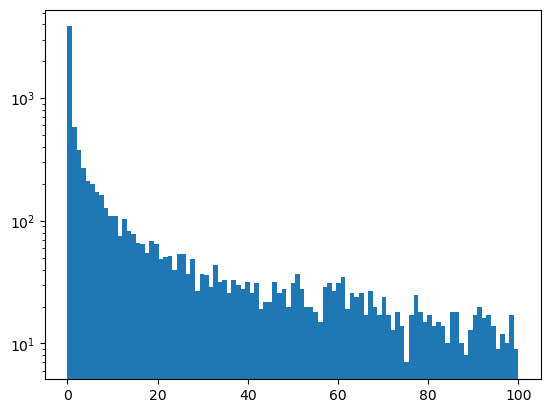

In [53]:
plt.figure()
plt.hist(expr.values[:,1:].mean(1), bins=np.linspace(0,100,100)) 
plt.yscale('log')
plt.show()


In [48]:
np.quantile(np.log2(expr.values[:, 1:].ravel().astype(np.float32) + 1), [0.05, 0.1, 0.25, 0.5, 0.95])

array([ 0.        ,  0.        ,  0.        ,  1.        ,  7.23840475,
       12.76797771])

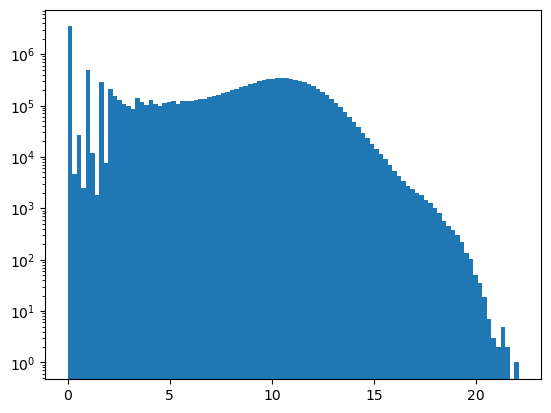

In [ ]:
plt.figure() 
plt.hist(np.log2(expr.values[:, 1:].ravel().astype(np.float32) + 1), bins=100)
#plt.hist(expr.values[:, 1:].ravel(), bins=100)
plt.yscale('log')
plt.show()

In [41]:

expr = expr.melt(id_vars='display_label', var_name='dbgap_rnaseq_sample', value_name='expression')
expr = expr.merge(rna2id, on='dbgap_rnaseq_sample', how='inner')

t = expr.expression.quantile(ALPHA2)
print(t)

expr = expr.assign(high_expr = lambda x: x.expression > t) 

expr.head()

0.0


,display_label,dbgap_rnaseq_sample,expression,dbgap_subject_id,low_expr
0,A1BG,BA2452R,5.0,2157,False
1,A1CF,BA2452R,0.0,2157,True
2,A2M,BA2452R,166.0,2157,False
3,A2ML1,BA2452R,0.0,2157,True
4,A3GALT2,BA2452R,3.0,2157,False


In [42]:
low_expr_unnorm_rel_fwd = expr[lambda x: x.low_expr][['dbgap_subject_id', 'display_label']].drop_duplicates().rename({'dbgap_subject_id':'src', 'display_label':'dst'}, axis=1).assign(src_type='dbgap_subject', dst_type='gene', relation='low_expr_unnorm_fwd')
low_expr_unnorm_rel_rev = expr[lambda x: x.low_expr][['dbgap_subject_id', 'display_label']].drop_duplicates().rename({'dbgap_subject_id':'dst', 'display_label':'src'}, axis=1).assign(dst_type='dbgap_subject', src_type='gene', relation='low_expr_unnorm_rev')

low_expr_unnorm_rel_fwd.dropna().to_csv('../../extdata/relations/beataml_low_expr_unnorm_rel_fwd.csv', index=False)
low_expr_unnorm_rel_rev.dropna().to_csv('../../extdata/relations/beataml_low_expr_unnorm_rel_rev.csv', index=False)

In [43]:
for rel in [low_expr_unnorm_rel_fwd, low_expr_unnorm_rel_rev]:
    print(rel.shape)
    

(2275243, 5)
(2275243, 5)
